In [1]:
from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 42

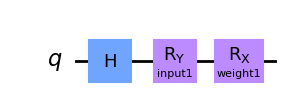

In [2]:
#Initiate QNNs
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

params1 = [Parameter("input1"), Parameter("weight1")]
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc1.draw("mpl", style="clifford")

In [3]:
# Y (x)n observable
from qiskit.quantum_info import SparsePauliOp

observable1 = SparsePauliOp.from_list([("Y" * qc1.num_qubits, 1)])

In [4]:
# Estimator
# Local statevector simulation If we needed to access cloud resources or Aer simulators, we would have to define the respective Estimator instances and pass them to the EstimatorQNN.
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import StatevectorEstimator as Estimator

estimator = Estimator() # EstimatorV2() for transpilation (required for pass_manager)
estimator_qnn = EstimatorQNN(
    circuit=qc1,
    observables=observable1,
    input_params=[params1[0]],
    weight_params=[params1[1]],
    estimator=estimator,
)
estimator_qnn

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


input parameters: ['input[0]', 'input[1]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


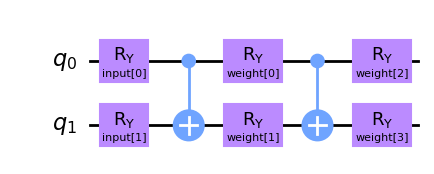

In [5]:
# Sampler
from qiskit.circuit import ParameterVector

inputs2 = ParameterVector("input", 2)
weights2 = ParameterVector("weight", 4)
print(f"input parameters: {[str(item) for item in inputs2.params]}")
print(f"weight parameters: {[str(item) for item in weights2.params]}")

qc2 = QuantumCircuit(2)
qc2.ry(inputs2[0], 0)
qc2.ry(inputs2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[0], 0)
qc2.ry(weights2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[2], 0)
qc2.ry(weights2[3], 1)

qc2.draw("mpl", style="clifford")

In [6]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()
sampler_qnn = SamplerQNN(circuit=qc2, input_params=inputs2, weight_params=weights2, sampler=sampler)
sampler_qnn

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [7]:
# Forward pass EstimatorQNN
estimator_qnn_input = algorithm_globals.random.random(estimator_qnn.num_inputs)
estimator_qnn_weights = algorithm_globals.random.random(estimator_qnn.num_weights)
print(
    f"Number of input features for EstimatorQNN: {estimator_qnn.num_inputs} \nInput: {estimator_qnn_input}"
)
print(
    f"Number of trainable weights for EstimatorQNN: {estimator_qnn.num_weights} \nWeights: {estimator_qnn_weights}"
)

Number of input features for EstimatorQNN: 1 
Input: [0.77395605]
Number of trainable weights for EstimatorQNN: 1 
Weights: [0.43887844]


In [8]:
# Forward pass SamplerQNN
sampler_qnn_input = algorithm_globals.random.random(sampler_qnn.num_inputs)
sampler_qnn_weights = algorithm_globals.random.random(sampler_qnn.num_weights)
print(
    f"Number of input features for SamplerQNN: {sampler_qnn.num_inputs} \nInput: {sampler_qnn_input}"
)
print(
    f"Number of trainable weights for SamplerQNN: {sampler_qnn.num_weights} \nWeights: {sampler_qnn_weights}"
)

Number of input features for SamplerQNN: 2 
Input: [0.85859792 0.69736803]
Number of trainable weights for SamplerQNN: 4 
Weights: [0.09417735 0.97562235 0.7611397  0.78606431]


In [9]:
# For the EstimatorQNN, the expected output shape for the forward pass is (1, num_qubits * num_observables) where 1 in our case is the number of samples:
estimator_qnn_forward = estimator_qnn.forward(estimator_qnn_input, estimator_qnn_weights)

print(
    f"Forward pass result for EstimatorQNN: {estimator_qnn_forward}. \nShape: {estimator_qnn_forward.shape}"
)

Forward pass result for EstimatorQNN: [[0.30739188]]. 
Shape: (1, 1)


In [10]:
# For the SamplerQNN (without a custom interpret function), the expected output shape for the forward pass is (1, 2**num_qubits). With a custom interpret function, the output shape will be (1, output_shape), where 1 in our case is the number of samples
sampler_qnn_forward = sampler_qnn.forward(sampler_qnn_input, sampler_qnn_weights)

print(
    f"Forward pass result for SamplerQNN: {sampler_qnn_forward}.  \nShape: {sampler_qnn_forward.shape}"
)

Forward pass result for SamplerQNN: [[0.02441406 0.26757812 0.50488281 0.203125  ]].  
Shape: (1, 4)


In [11]:
# Estimator batched forward pass
estimator_qnn_forward_batched = estimator_qnn.forward(
    [estimator_qnn_input, estimator_qnn_input], estimator_qnn_weights
)

print(
    f"Forward pass result for EstimatorQNN: {estimator_qnn_forward_batched}.  \nShape: {estimator_qnn_forward_batched.shape}"
)

Forward pass result for EstimatorQNN: [[0.28146919]
 [0.26929895]].  
Shape: (2, 1)


In [12]:
# Sampler barched forward pass
sampler_qnn_forward_batched = sampler_qnn.forward(
    [sampler_qnn_input, sampler_qnn_input], sampler_qnn_weights
)

print(
    f"Forward pass result for SamplerQNN: {sampler_qnn_forward_batched}.  \nShape: {sampler_qnn_forward_batched.shape}"
)

Forward pass result for SamplerQNN: [[0.0078125  0.26171875 0.52832031 0.20214844]
 [0.01757812 0.23828125 0.546875   0.19726562]].  
Shape: (2, 4)


In [ ]:
# qnn = ...QNN(..., input_gradients=True) input gradients are required for TorchConnector

In [13]:
# Backward Pass without Input Gradients - EstimatorQNN
estimator_qnn_input_grad, estimator_qnn_weight_grad = estimator_qnn.backward(
    estimator_qnn_input, estimator_qnn_weights
)

print(
    f"Input gradients for EstimatorQNN: {estimator_qnn_input_grad}.  \nShape: {estimator_qnn_input_grad}"
)
print(
    f"Weight gradients for EstimatorQNN: {estimator_qnn_weight_grad}.  \nShape: {estimator_qnn_weight_grad.shape}"
)

Input gradients for EstimatorQNN: None.  
Shape: None
Weight gradients for EstimatorQNN: [[[0.63272767]]].  
Shape: (1, 1, 1)


In [14]:
# Backward Pass without Input Gradients -SamplerQNN
sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(
    f"Input gradients for SamplerQNN: {sampler_qnn_input_grad}.  \nShape: {sampler_qnn_input_grad}"
)
print(
    f"Weight gradients for SamplerQNN: {sampler_qnn_weight_grad}.  \nShape: {sampler_qnn_weight_grad.shape}"
)

Input gradients for SamplerQNN: None.  
Shape: None
Weight gradients for SamplerQNN: [[[ 0.00634766 -0.12109375 -0.04248047 -0.09716797]
  [ 0.22802734 -0.08642578  0.07226562 -0.22558594]
  [-0.48486328  0.32421875 -0.33789062  0.10009766]
  [ 0.25048828 -0.11669922  0.30810547  0.22265625]]].  
Shape: (1, 4, 4)


In [23]:
# Backward pass with input gradients
estimator_qnn.input_gradients = True
sampler_qnn.input_gradients = True

In [24]:
estimator_qnn_input_grad, estimator_qnn_weight_grad = estimator_qnn.backward(
    estimator_qnn_input, estimator_qnn_weights
)

print(
    #f"Input gradients for EstimatorQNN: {estimator_qnn_input_grad}.  \nShape: {estimator_qnn_input_grad.shape}"
    f"Input gradients for EstimatorQNN: {estimator_qnn_input_grad}. \n"

)
print(
    f"Weight gradients for EstimatorQNN: {estimator_qnn_weight_grad}.  \nShape: {estimator_qnn_weight_grad.shape}"
)

Input gradients for EstimatorQNN: [[[0.3038852]]]. 

Weight gradients for EstimatorQNN: [[[0.63272767]]].  
Shape: (1, 1, 1)


In [25]:
sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(
    #f"Input gradients for SamplerQNN: {sampler_qnn_input_grad}.  \nShape: {sampler_qnn_input_grad.shape}"
    f"Input gradients for SamplerQNN: {sampler_qnn_input_grad}.  \n"

)
print(
    f"Weight gradients for SamplerQNN: {sampler_qnn_weight_grad}.  \nShape: {sampler_qnn_weight_grad.shape}"
)

Input gradients for SamplerQNN: [[[-0.05908203 -0.10351562]
  [ 0.38916016 -0.19091797]
  [-0.34814453  0.10253906]
  [ 0.01806641  0.19189453]]].  

Weight gradients for SamplerQNN: [[[ 0.00341797 -0.10400391 -0.07714844 -0.10205078]
  [ 0.22607422 -0.09033203  0.07275391 -0.22949219]
  [-0.48535156  0.32324219 -0.31347656  0.09716797]
  [ 0.25585938 -0.12890625  0.31787109  0.234375  ]]].  
Shape: (1, 4, 4)


In [27]:
# Advanced functionality EstimatorQNN with Multiple Observables
observable2 = SparsePauliOp.from_list([("Z" * qc1.num_qubits, 1)])

estimator_qnn2 = EstimatorQNN(
    circuit=qc1,
    observables=[observable1, observable2],
    input_params=[params1[0]],
    weight_params=[params1[1]],
    estimator=estimator,
)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [29]:
estimator_qnn_forward2 = estimator_qnn2.forward(estimator_qnn_input, estimator_qnn_weights)
estimator_qnn_input_grad2, estimator_qnn_weight_grad2 = estimator_qnn2.backward(
    estimator_qnn_input, estimator_qnn_weights
)

print(f"Forward output for EstimatorQNN1: {estimator_qnn_forward.shape}")
print(f"Forward output for EstimatorQNN2: {estimator_qnn_forward2.shape}")
print(f"Backward output for EstimatorQNN1: {estimator_qnn_weight_grad.shape}")
print(f"Backward output for EstimatorQNN2: {estimator_qnn_weight_grad2.shape}")

Forward output for EstimatorQNN1: (1, 1)
Forward output for EstimatorQNN2: (1, 2)
Backward output for EstimatorQNN1: (1, 1, 1)
Backward output for EstimatorQNN2: (1, 2, 1)


In [30]:
# SamplerQNN with custom interpret parity (binary clasification)

parity = lambda x: "{:b}".format(x).count("1") % 2
output_shape = 2  # parity = 0, 1

sampler_qnn2 = SamplerQNN(
    circuit=qc2,
    input_params=inputs2,
    weight_params=weights2,
    interpret=parity,
    output_shape=output_shape,
    sampler=sampler,
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [31]:
sampler_qnn_forward2 = sampler_qnn2.forward(sampler_qnn_input, sampler_qnn_weights)
sampler_qnn_input_grad2, sampler_qnn_weight_grad2 = sampler_qnn2.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(f"Forward output for SamplerQNN1: {sampler_qnn_forward.shape}")
print(f"Forward output for SamplerQNN2: {sampler_qnn_forward2.shape}")
print(f"Backward output for SamplerQNN1: {sampler_qnn_weight_grad.shape}")
print(f"Backward output for SamplerQNN2: {sampler_qnn_weight_grad2.shape}")

Forward output for SamplerQNN1: (1, 4)
Forward output for SamplerQNN2: (1, 2)
Backward output for SamplerQNN1: (1, 4, 4)
Backward output for SamplerQNN2: (1, 2, 4)
